In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}

import os
import sys
import time
import string
import logging
import tempfile
logging.basicConfig(level=logging.INFO)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1 import inset_locator
import matplotlib.font_manager as fm
from IPython.display import clear_output

plt.style.use("seaborn-darkgrid")
plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams["font.size"] = 18
plt.rcParams['savefig.dpi'] = 600

SAVE_FIGURES = True

if SAVE_FIGURES:
    os.makedirs(os.path.join(os.pardir, "images"), exist_ok=True)
    
sys.path.insert(0, os.pardir)
import squids

In [2]:
import superscreen as sc
sc.version_table()

Software,Version
SuperScreen,0.1.1
Numpy,1.20.3
SciPy,1.6.3
matplotlib,3.4.3
ray,1.4.1
IPython,7.24.1
Python,"3.9.5 (default, May 18 2021, 12:31:01) [Clang 10.0.0 ]"
OS,posix [darwin]
Number of CPUs,"Physical: 2, Logical: 4"
BLAS Info,OPENBLAS


## `Parameter` demo

In [3]:
from superscreen import Parameter

def f(x, y, a=1, b=0):
    return a * x**2 + b * y
    
param = Parameter(f, a=0, b=1)
print(param) # Parameter<f(a=0, b=1)>

other_param = Parameter(f, a=2, b=3)
print(other_param) # Parameter<f(a=2, b=3)>

print(param(0, 0) == f(0, 0, a=0, b=1)) # True
print(other_param(1, 2) == f(1, 2, a=2, b=3)) # True

param_squared = param ** 2
print(param_squared) # CompositeParameter<(f(a=0, b=1) ** 2)>

print(param_squared(3, 4) == f(3, 4, a=0, b=1) ** 2) # True
print(
    (5 * param_squared / other_param)(5, 6)
    == 5 * f(5, 6, a=0, b=1) ** 2 / f(5, 6, a=2, b=3)
) # True

Parameter<f(a=0, b=1)>
Parameter<f(a=2, b=3)>
True
True
CompositeParameter<(f(a=0, b=1) ** 2)>
True
True


## Ring with a slit (Code Block 1)

In [4]:
import superscreen as sc
from superscreen.geometry import circle, box

length_units = "um"
ro = 3  # outer radius
ri = 1  # inner radius
slit_width = 0.25
layer = sc.Layer("base", Lambda=1.0, z0=0)

ring = circle(ro)
hole = circle(ri)
slit = box(slit_width, 1.5 * (ro - ri), center=(0, -(ro + ri) / 2))

film = sc.Polygon.from_difference(
    [ring, slit, hole], name="ring_with_slit", layer="base"
).resample(500)
bounding_box = sc.Polygon("bounding_box", layer="base", points=circle(1.2 * ro))

device = sc.Device(
    film.name,
    layers=[layer],
    films=[film],
    abstract_regions=[bounding_box],
    length_units=length_units,
)

INFO:superscreen.device.device:Generating mesh...
INFO:superscreen.device.device:Finished generating mesh with 4021 points and 7879 triangles.
INFO:superscreen.device.device:Calculating weight matrix.
INFO:superscreen.device.device:Calculating Laplace operator.
INFO:superscreen.device.device:Calculating kernel matrix.
INFO:superscreen.solve:Calculating base response to applied field.


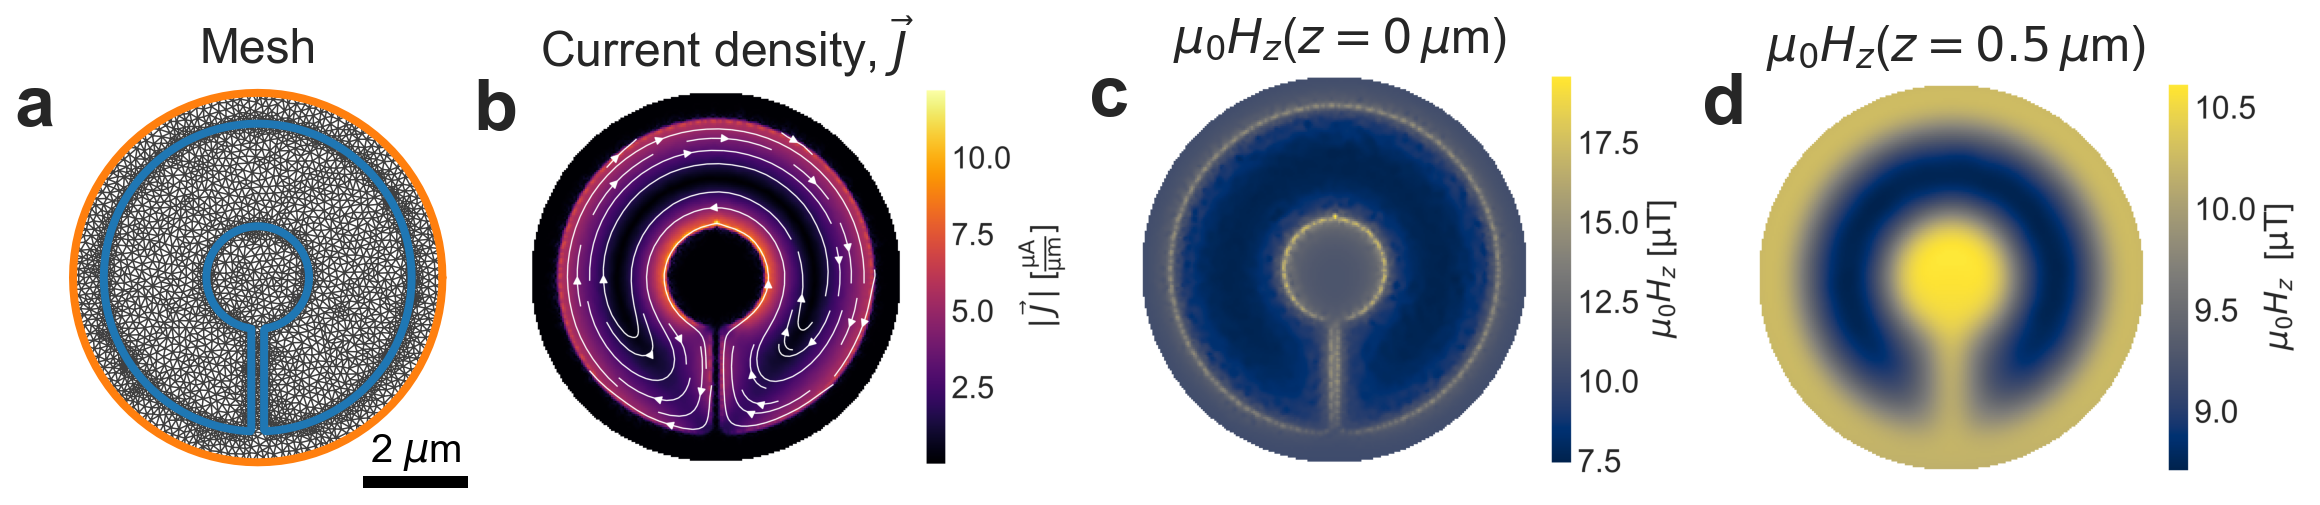

In [5]:
fig, axes = plt.subplots(
    1, 4,
    figsize=(16, 4),
    facecolor="w",
    constrained_layout=True,
    gridspec_kw=dict(width_ratios=[0.725, 1, 1, 1])
)

device.make_mesh(min_points=5000, optimesh_steps=None)

solution = sc.solve(
    device,
    applied_field=sc.sources.ConstantField(10),
    field_units="uT",
)[-1]

device.plot(
    ax=axes[0], lw=4, legend=False, mesh=True,
    mesh_kwargs=dict(color="k", lw=0.75, alpha=0.75)
)
    
scale = 2
um = "$\\mu$m"
scalebar = AnchoredSizeBar(
    transform=axes[0].transData,
    size=scale,
    size_vertical=scale/10,
    loc="lower right",
    label=f"{scale} {um}",
    color="k",
    frameon=False,
    label_top=True,
    pad=-0.25,
    fontproperties=fm.FontProperties(size=20),
)
axes[0].add_artist(scalebar)

# Sub-figure for current density
fig_j, (ax_j, ) = solution.plot_currents(figsize=(5, 4))
ax_j.axis("off")
ax_j.set_title("")

# Sub-figure for magnetic field at z = 0 um
fig_h, (ax_h, ) = solution.plot_fields(figsize=(5, 4))
ax_h.axis("off")
ax_h.set_title("")

# Sub-figure for magnetic field at z = 0.5 um
fig_hf, (ax_hf, ) = solution.plot_field_at_positions(device.points, zs=0.5, figsize=(5, 4))
ax_hf.axis("off")
ax_hf.set_title("")

# Save sub-figures to a temporary directory and load them as images.
with tempfile.TemporaryDirectory() as path:
    fig_h.savefig(os.path.join(path, "fields.png"), bbox_inches="tight")
    fig_j.savefig(os.path.join(path, "currents.png"), bbox_inches="tight")
    fig_hf.savefig(os.path.join(path, "fields_at_position.png"), bbox_inches="tight")
    im_h = plt.imread(os.path.join(path, "fields.png"))
    im_j = plt.imread(os.path.join(path, "currents.png"))
    im_hf = plt.imread(os.path.join(path, "fields_at_position.png"))

plt.close(fig_h)
plt.close(fig_j)
plt.close(fig_hf)
    
axes[1].imshow(im_j)
axes[2].imshow(im_h)
axes[3].imshow(im_hf)

titles = [
    "Mesh",
    "Current density, $\\vec{J}$",
    "$\\mu_0H_z$($z=0\\,\\mu$m)",
    "$\\mu_0H_z$($z=0.5\\,\\mu$m)",
]

for i, (ax, label, title) in enumerate(zip(axes, string.ascii_lowercase, titles)):
    ax.set_aspect("equal")
    ax.grid(False)
    ax.axis("off")
    ax.set_title(title, x=0.5 - 0.125 * bool(i), fontsize=24)
    ax.text(0, 1, label, weight="bold", size=36, transform=ax.transAxes, ha="right", va="top")
    
if SAVE_FIGURES:
    fig.savefig("../images/ring_with_slit.pdf", bbox_inches="tight")

## Pearl Vortices

In [6]:
# Create a device representing square thin film.
device = sc.Device(
    "film",
    layers=[sc.Layer("base", Lambda=0, z0=0)],
    films=[sc.Polygon("film", layer="base", points=sc.geometry.box(20))],
    # Add an abstract_polygon near the vortex position so that
    # that region will be meshed densely.
    abstract_regions=[
        sc.Polygon("circle", layer="base", points=sc.geometry.circle(0.25)),
    ],
    length_units="um",
)
device.make_mesh(min_points=5000, optimesh_steps=50)
# Specify the vortex position.
vortices = [sc.Vortex(x=0, y=0, layer="base")]

INFO:superscreen.device.device:Generating mesh...
INFO:superscreen.device.device:Optimizing mesh with 5001 vertices.
INFO:superscreen.device.device:Finished generating mesh with 5001 points and 9805 triangles.
INFO:superscreen.device.device:Calculating weight matrix.
INFO:superscreen.device.device:Calculating Laplace operator.
INFO:superscreen.device.device:Calculating kernel matrix.


In [7]:
# Specify coordinates at which to calculate a cross-section of the
# resulting field distribution.
cut_x = np.linspace(-4, 4, 201) # [device.length_units]
cut_y = 0 * np.ones_like(cut_x)
cut_z = 1 * np.ones_like(cut_x)
x_cut_coords = np.stack([cut_x, cut_y, cut_z], axis=1)
z_cut_coords = np.linspace(0.2, 5, 81)
Bz_x_cuts = []
Bz_x_cuts_fourier = []
Bz_z_cuts = []
Bz_z_cuts_fourier = []

fluxoid_radius = 1 # microns
fluxoids = []
solutions = []
fluxoid_polygon = sc.geometry.circle(fluxoid_radius, points=201)
# Sweep Lambda, solve the model, and evaluate the field at the given coordinates.
Lambdas = np.linspace(0, 2, 5) # [device.length_units]

for Lambda in Lambdas:
    device.layers["base"].Lambda = Lambda
    solution = sc.solve(
        device=device, vortices=vortices, field_units="Phi_0/um**2"
    )[-1]
    solutions.append(solution)
    fluxoids.append(
        solution.polygon_fluxoid(
            fluxoid_polygon, grid_shape=200, with_units=False,
        )["base"]
    )
    Bz_x = solution.field_at_position(x_cut_coords).m
    Bz_x_cuts.append(Bz_x)
    Bz_z = solution.field_at_position((0, 0), zs=z_cut_coords).m
    Bz_z_cuts.append(Bz_z)
    
    # Fourier transform calculation of Pearl vortex field profile
    xmin, xmax = device.points[:, 0].min(), device.points[:, 0].max()
    ymin, ymax = device.points[:, 1].min(), device.points[:, 1].max()
    x = np.linspace(xmin, xmax, 500)
    y = np.linspace(ymin, ymax, 500)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    phi_0 = 1
    z0 = cut_z[0]
    Lambda = 2 * Lambda
    kmaxx = np.pi / dx
    kmaxy = np.pi / dy
    kx = np.linspace(-kmaxx, kmaxx, x.shape[0])
    ky = np.linspace(-kmaxy, kmaxy, y.shape[0])
    KX, KY = np.meshgrid(kx, ky)
    K = np.sqrt(KX ** 2 + KY ** 2)
    # calculate expression of Pearl vortex in Fourier space
    hzk = phi_0 * np.exp(-K * z0)/(1 + K * Lambda)
    # shift Forier expression
    hzk = np.fft.fftshift(hzk)
    # inverse shifted Fourier expression
    hzf = np.abs(np.fft.ifft2(hzk))
    # get unit right for B field expression
    hzf = np.fft.fftshift(hzf) / (dx * dy)
    hzf = (hzf * device.ureg("Phi_0 / um ** 2")).to(solution.field_units).m 
    Bz_x_cuts_fourier.append(np.interp(cut_x, x, hzf[np.argmin(np.abs(y - 0)), :]))
    hzz = []
    for z0 in z_cut_coords:
        # calculate expression of Pearl vortex in Fourier space
        hzk = phi_0 * np.exp(-K * z0)/(1 + K * Lambda)
        # shift Forier expression
        hzk = np.fft.fftshift(hzk)
        # inverse shifted Fourier expression
        hzf = np.abs(np.fft.ifft2(hzk))
        # get unit right for B field expression
        hzf = np.fft.fftshift(hzf) / (dx * dy)
        hzz.append(hzf.max())
    Bz_z_cuts_fourier.append(
        (np.array(hzz) * device.ureg("Phi_0 / um ** 2")).to(solution.field_units).m
    )

INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.solve:Calculating base response to applied field.


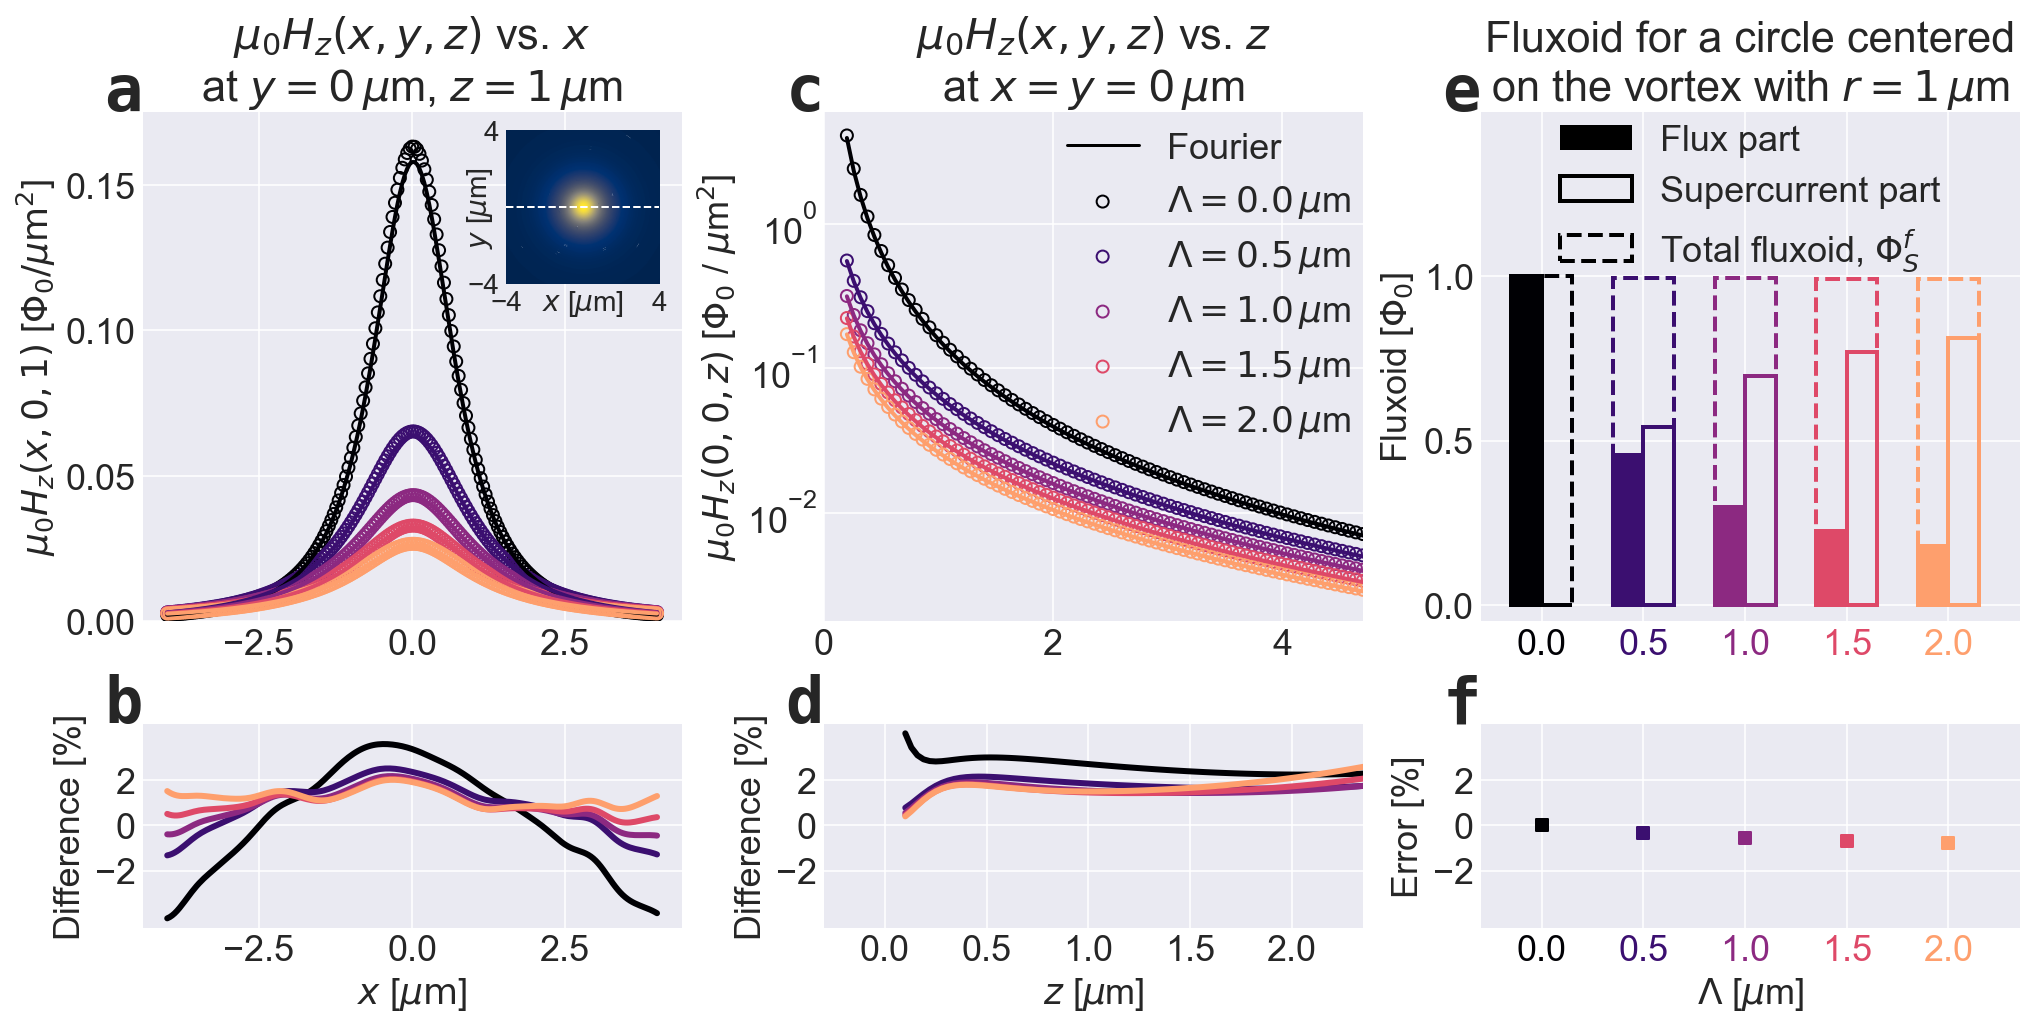

In [8]:
fig, axes = plt.subplots(
    2, 3,
    figsize=(14, 7), 
    constrained_layout=True,
    gridspec_kw=dict(height_ratios=[2.5, 1]),
)
(ax, bx), (cx, dx), (ex, fx) = axes.T
colors = plt.get_cmap("magma")(np.linspace(0, 1, Lambdas.size + 1))

width = 0.3
lw = 2
ex.bar(-2, 1, color="k", lw=2, label="Flux part")
ex.bar(-2, 1, color="k", fill=False, ls="-", lw=2, label="Supercurrent part")
ex.bar(-2, 1, color="k", fill=False, ls="--", lw=2, label="Total fluxoid, $\\Phi_S^f$")
for i, (fluxoid, Lambda, color) in enumerate(zip(fluxoids, Lambdas, colors)):
    ex.bar(
        i - width / 2,
        fluxoid.flux_part,
        fc=color,
        ec=color,
        lw=lw,
        width=width,
    )
    ex.bar(
        i + width / 2,
        fluxoid.supercurrent_part,
        fill=False,
        ec=color,
        lw=lw,
        ls="-",
        width=width,
    )
    ex.bar(
        i,
        sum(fluxoid),
        ec=color,
        fill=False,
        lw=lw,
        ls="--",
        zorder=12,
        width=2 * width,
    )
    fx.scatter(i, 100 * (sum(fluxoid) - 1), color=color, marker="s")

ex.set_yticks([0, 0.5, 1])
ex.set_xlim(-2 * width, len(Lambdas) - width)
ex.set_ylim(-0.05, 1.5)
ex.legend(bbox_to_anchor=(0.5, 1.04), loc="upper center", fontsize=18)
ex.set_ylabel("Fluxoid [$\\Phi_0$]")
fx.set_ylabel("Error [%]")
ex.set_title(
    f"Fluxoid for a circle centered\non the vortex with $r={{{1}}}\\,\\mu$m"
)
fx.sharex(ex)
    
for a in (ex, fx):
    a.set_xticks(range(len(Lambdas)))
    a.set_xticklabels(Lambdas)
    for label, color in zip(a.xaxis.get_ticklabels(), colors):
        label.set_color(color)
        
fx.set_xlabel("$\\Lambda$ [$\\mu$m]")

for hz, hzf, Lambda, color in zip(Bz_x_cuts, Bz_x_cuts_fourier, Lambdas, colors):
    label = f"$\\Lambda={{{Lambda:.1f}}}\\,\\mu$m"
    ax.scatter(cut_x, hz, marker="o", color=color, label=label, fc="none")
    ax.plot(cut_x, hzf, "-", color=color, lw=2, alpha=1)
    bx.plot(cut_x, 100 * (hz - hzf) / hzf, color=color, lw=3, label=label)

ax.set_ylim(0, 0.175)
ax.set_ylabel("$\\mu_0H_z(x, 0, 1)$ [$\\Phi_0 / \\mu\\mathrm{m}^2$]")
ax.set_yticks([0, 0.05, 0.1, 0.15])
bx.set_xlabel("$x$ [$\\mu\\mathrm{m}$]")
bx.set_ylabel("Difference [%]")
ax.set_title("$\\mu_0H_z(x, y, z)$ vs. $x$\nat $y=0\\,\\mu$m, $z = 1\\,\\mu$m")
bx.sharex(ax)

cx.plot(-1, 1, "k-", label="Fourier")
for i, (hz, hzz, Lambda, color) in enumerate(zip(Bz_z_cuts, Bz_z_cuts_fourier, Lambdas, colors)):
    cx.scatter(z_cut_coords, hz, marker="o", fc="none", color=color, label=f"$\\Lambda = {{{Lambda:.1f}}}\\,\\mu$m")
    cx.plot(z_cut_coords, hzz, f"-", lw=2, color=color)
    
    dx.plot(
        z_cut_coords,
        100 * (hz - hzz) / hzz,
        f"-",
        color=color,
        lw=3,
        label=f"$\\Lambda = {{{Lambda:.1f}}}\\,\\mu$m"
    )
cx.set_title("$\\mu_0H_z(x, y, z)$ vs. $z$\nat $x=y=0\\,\\mu$m")
cx.set_ylabel("$\\mu_0H_z(0, 0, z)$ [$\\Phi_0$ / $\\mu$m${}^2$]")
cx.legend(bbox_to_anchor=(1.04, 1.025), loc="upper right", fontsize=18)
cx.set_xlim(0, ex.get_xlim()[1])
cx.set_yscale("log")
dx.set_xlabel("$z$ [$\\mu$m]")
dx.set_ylabel("Difference [%]")
dx.sharey(bx)
dx.sharex(ex)
fx.sharey(dx)

dx.set_yticks([-2, 0, 2])

for a, s in zip(axes.T.flat, string.ascii_lowercase):
    y0 = 1.1 if a in axes[0] else 1.25
    a.text(0, y0, s, family="monospace", weight="bold", size=32, transform=a.transAxes, ha="right", va="top")
    
inset = inset_locator.inset_axes(
    ax,
    height="30%",
    width="30%",
    loc="upper right",
    bbox_to_anchor=(0, 0, 1, 1),
    bbox_transform=ax.transAxes,
)
fontsize = 14
points = solutions[0].device.points
triangles = solutions[0].device.triangles
hz = solutions[0].field_at_position(points, zs=1, units="Phi_0 / um**2", with_units=False)
levels = np.linspace(0, hz.max(), 201)
im = inset.tricontourf(points[:, 0], points[:, 1], triangles, hz, cmap="cividis", levels=levels)
for pc in im.collections:
    pc.set_edgecolor("face")

inset.set_xlim(-4, 4)
inset.set_ylim(-4, 4)
for axis in (inset.xaxis, inset.yaxis):
    axis.set_ticks([-4, 4])
    axis.set_tick_params(labelsize=fontsize)
inset.set_xlabel("$x$ [$\\mu$m]", fontsize=fontsize, labelpad=-fontsize)
inset.set_ylabel("$y$ [$\\mu$m]", fontsize=fontsize, labelpad=-fontsize)
inset.set_aspect("equal")
inset.grid(False)
inset.axhline(0, ls="--", color="w", lw=1, alpha=1)

if SAVE_FIGURES:
    fig.savefig("../images/pearl.pdf", bbox_inches="tight")

## Ring self-inductance

In [9]:
def make_ring(r1, r2, Lambda, points1, points2):
    layers = [sc.Layer("base", Lambda=Lambda, z0=0)]
    films = [
        sc.Polygon("ring", layer="base", points=sc.geometry.circle(r2, points=points2)),
    ]
    holes = [
        sc.Polygon("hole", layer="base", points=sc.geometry.circle(r1, points=points1)),
    ]
    abstract_regions = [
        sc.Polygon("bbox", layer="base", points=sc.geometry.circle(r2 * 1.2)),
    ]
    return sc.Device(
        "ring",
        layers=layers,
        films=films,
        holes=holes,
        abstract_regions=abstract_regions,
    )

In [10]:
b = 1 # outer radius
a_vals = np.linspace(0.05, 0.975, 21) * b # inner radius
Lambdas = np.array([0, 0.01, 0.03, 0.1, 0.3]) * b
a_over_b = a_vals / b
Lambda_over_b = Lambdas / b
results = [[] for _ in Lambdas]
mesh_gen_times = []
solve_times = [[] for _ in Lambdas]
fluxoid_times = [[] for _ in Lambdas]

I_circ = sc.Device.ureg("1 mA")
circ_currents = dict(hole=str(I_circ))

for i, a in enumerate(a_vals):
    print(f"({i + 1} / {len(a_vals)})", a, flush=True)
    t0 = time.perf_counter()
    device = make_ring(a, b, 0, 100, 400)
    device.make_mesh(min_points=5000, optimesh_steps=None)
    mesh_gen_times.append(time.perf_counter() - t0)
    for j, Lambda in enumerate(Lambdas):
        device.layers_list[0].Lambda = Lambda
        # Instead of calling...
        # m = device.mutual_inductance_matrix()[0, 0]
        # ... split up the solve() and hole_fluxoid() calls so we can time them separately.
        t0 = time.perf_counter()
        solution = sc.solve(device, circulating_currents=circ_currents)[-1]
        solve_times[j].append(time.perf_counter() - t0)
        t0 = time.perf_counter()
        m = (sum(solution.hole_fluxoid("hole")) / I_circ)
        results[j].append((m / (a * device.ureg("mu_0 * um"))).to_base_units().m)
        fluxoid_times[j].append(time.perf_counter() - t0)
    clear_output(wait=True)

(21 / 21) 0.975


INFO:superscreen.device.device:Generating mesh...
INFO:superscreen.device.device:Finished generating mesh with 5227 points and 10253 triangles.
INFO:superscreen.device.device:Calculating weight matrix.
INFO:superscreen.device.device:Calculating Laplace operator.
INFO:superscreen.device.device:Calculating kernel matrix.
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.solve:Calculating base response to applied field.


In [11]:
for label, times in zip(
    ["make_mesh()", "solve()", "hole_fluxoid()"],
    [mesh_gen_times, solve_times, fluxoid_times]
):
    print(f"{label}: {np.mean(times):.3f} +/- {np.std(times):.3f} seconds")

make_mesh(): 7.587 +/- 3.780 seconds
solve(): 2.953 +/- 2.112 seconds
hole_fluxoid(): 3.629 +/- 1.708 seconds


Load results from Brandt & Clem 2005 (DOI: 10.1103/PhysRevB.69.184509) and Khapaev 1997 (DOI: 10.1088/0953-2048/10/6/002).

The CSV files below are Figures 2 and 1 of `10.1103/PhysRevB.69.184509` and `10.1088/0953-2048/10/6/002` respectively,
which were digitized using https://automeris.io/WebPlotDigitizer/.

In [12]:
import pandas as pd

In [13]:
df = pd.read_csv("brandt_clem_2005_fig2.csv", skiprows=[1])
dfs = [df[df.columns[i:i+2]].dropna() for i in range(0, len(df.columns), 2)]
for d in dfs:
    d.columns = ["a_over_b", "L_over_mu0a"]
    d.set_index("a_over_b", inplace=True)

In [14]:
dfk = pd.read_csv("khapaev_1997_fig1.csv", skiprows=[1])
dfks = [dfk[dfk.columns[i:i+2]].dropna() for i in range(0, len(dfk.columns), 2)]
for d in dfks:
    d.columns = ["b_over_a", "L_over_mu0a"]
    d.set_index("b_over_a", inplace=True)

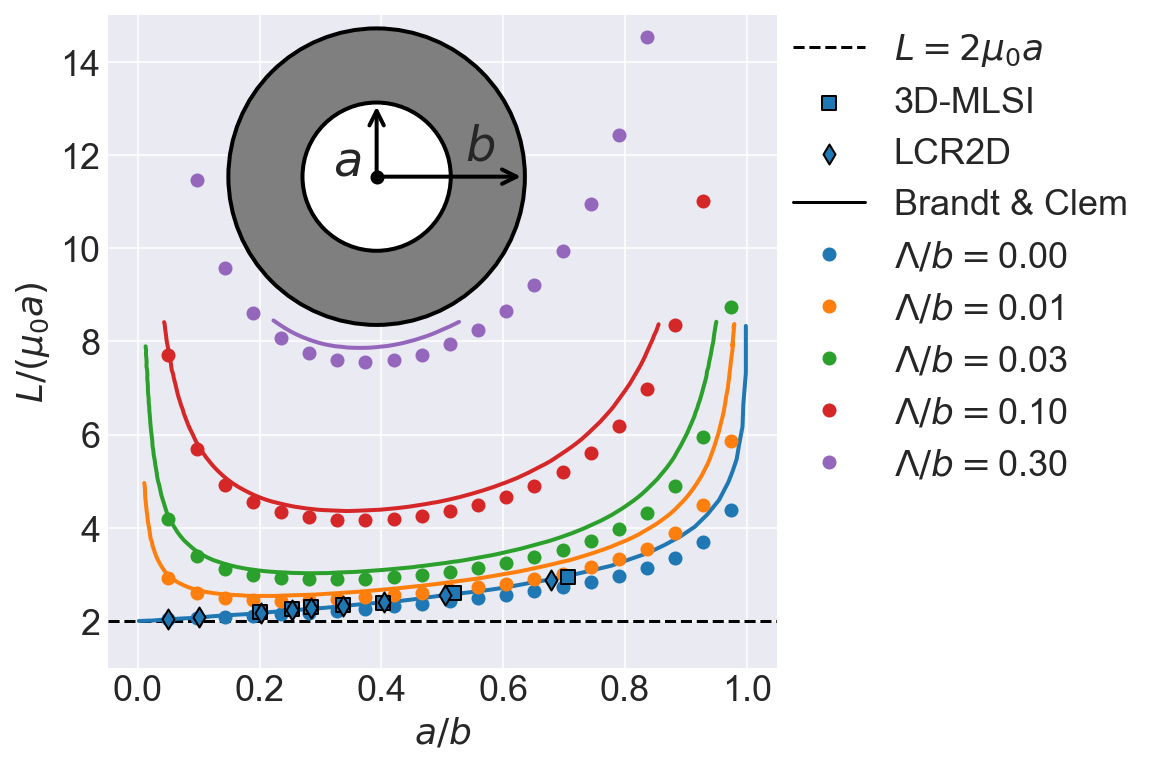

In [15]:
fig, ax = plt.subplots(figsize=(6, 6))

kwargs = dict(fc="C0", ec="k", zorder=12, lw=1, s=50)
# Plot analytical result
ax.axhline(2, color="k", ls="--", label="$L = 2\\mu_0 a$")
# Plot Khapaev results
ax.scatter(1 / dfks[0].index, dfks[0]["L_over_mu0a"], marker="s", label="3D-MLSI", **kwargs)
ax.scatter(1 / dfks[1].index, dfks[1]["L_over_mu0a"], marker="d", label="LCR2D", **kwargs)
# Plot Brandt and Clem results
ax.plot(-1, -1, "k-", label="Brandt & Clem") # Hidden line for the legend
for d, Lambda in zip(dfs, Lambda_over_b):
    ax.plot(d.index, d["L_over_mu0a"].values, lw=2, ls="-")
# Plot SuperScreen results
for i, (L, Lambda) in enumerate(zip(results, Lambda_over_b)):
    ax.plot(a_over_b, L, color=f"C{i}", marker="o", ls="", label=f"$\\Lambda / b = ${Lambda:.2f}")
    
ax.set_ylim(1, 15)
ax.set_xlim(-0.05, 1.05)
ax.set_xlabel("$a / b$")
ax.set_ylabel("$L / (\\mu_0 a)$")

# Re-order legend items.
handles = list(zip(*ax.get_legend_handles_labels()))
handles = handles[:1] + handles[-2:] + handles[1:-2]
handles, labels = zip(*handles)
ax.legend(handles, labels, bbox_to_anchor=(0.975, 1.025), loc="upper left")

# Add a sketch of the ring in an inset.
inset = inset_locator.inset_axes(
    ax, width="50%", height="50%", loc='lower left',
    bbox_to_anchor=(0.125, 0.475, 1, 1), bbox_transform=ax.transAxes
)
inset.set_aspect("equal")
inset.axis("off")
inset.set_xlim(-1.1, 1.1)
inset.set_ylim(-1.1, 1.1)

washer = plt.Circle((0, 0), 1, color="tab:gray", ec="k", lw=2)
hole_size = 0.5
hole = plt.Circle((0, 0), hole_size, color="w", ec="k", lw=2)
inset.add_artist(washer)
inset.add_artist(hole)
inset.text(-0.2, 0.25, "$a$", va="top", ha="center", size=24)
inset.annotate(
    text="",
    xy=[0, hole_size],
    xytext=[0, 0],
    arrowprops=dict(arrowstyle="->", lw=2, color="k"),
)
inset.text(0.8, 0.2, "$b$", va="center", ha="right", size=24)
inset.annotate(
    text="",
    xy=[1, 0],
    xytext=[0, 0],
    arrowprops=dict(arrowstyle="->", lw=2, color="k"),
)
inset.plot(0, 0, "ko")

if SAVE_FIGURES:
    fig.savefig("../images/inductance.pdf", bbox_inches="tight")

## SQUID mutual inductance

In [16]:
um = "$\\mu$m"

squid_funcs = {
    f"Small\n$r_{{i,PL}} = $0.1 {um}\n$r_{{i,FC}} = $0.5 {um}": squids.small.make_squid,
    f"Medium\n$r_{{i,PL}} = $0.3 {um}\n$r_{{i,FC}} = $1.0 {um}": squids.medium.make_squid,
    f"Large\n$r_{{i,PL}} = $1.0 {um}\n$r_{{i,FC}} = $2.5 {um}": squids.large.make_squid,
    f"X-Large\n$r_{{i,PL}} = $3.0 {um}\n$r_{{i,FC}} = $ 6.0 {um}": squids.xlarge.make_squid,
}
exclude = ["bounding_box", "circle"]

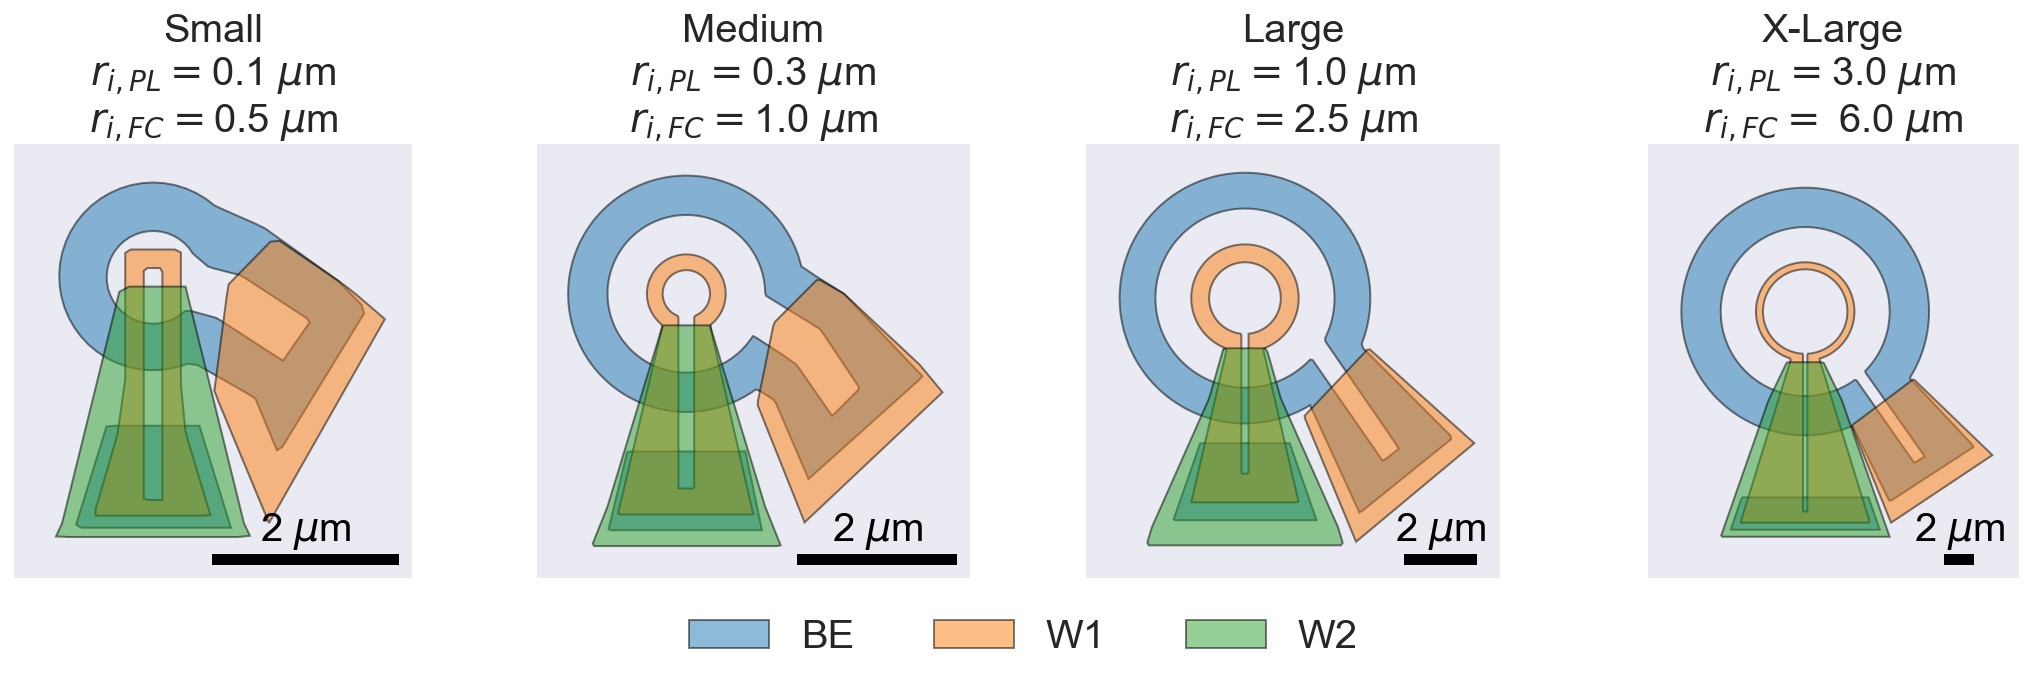

In [17]:
fig, axes = plt.subplots(1, len(squid_funcs), figsize=(15, 4), constrained_layout=True)

for ax, (name, make_squid), scale in zip(axes, squid_funcs.items(), [2, 2, 2, 2]):
    squid = make_squid()
    squid.draw(ax=ax, exclude=exclude, layer_order="decreasing", alpha=0.5)
    ax.set_title(name, fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ymin, ymax = ax.get_ylim()
    scalebar = AnchoredSizeBar(
        transform=ax.transData,
        size=scale,
        size_vertical=(ymax - ymin) / 50,
        loc="lower right",
        label=f"{scale} {um}",
        color="k",
        frameon=False,
        label_top=True,
        pad=0.25,
        fontproperties=fm.FontProperties(size=20),
    )
    ax.add_artist(scalebar)

handles = axes[-1].artists[::2]
labels = ["BE", "W1", "W2"]
fig.legend(handles, labels, bbox_to_anchor=(0.5, 0), loc="upper center", ncol=3, fontsize=20)

In [18]:
min_points = 6_000
optimesh_steps = 40
iterations = 10

solve_times = {}
all_fluxoids = {}
all_solutions = {}
all_mutuals = {}
I_fc = sc.Device.ureg("1 mA")

for name, make_squid in squid_funcs.items():
    squid = make_squid(align_layers="bottom")
    squid.make_mesh(min_points=min_points, optimesh_steps=optimesh_steps)
    t0 = time.perf_counter()
    solutions = sc.solve(
        squid,
        circulating_currents={"fc_center": str(I_fc)},
        field_units="mT",
        current_units="mA",
        iterations=iterations,
    )
    t1 = time.perf_counter()
    solve_times[name] = t1 - t0
    all_solutions[name] = solutions
    all_mutuals[name] = []
    all_fluxoids[name] = []
    for solution in solutions:
        phi = solution.hole_fluxoid("pl_center")
        M = (sum(phi) / I_fc).to("Phi_0 / A")
        print(M, flush=True)
        all_mutuals[name].append(M.magnitude)
        all_fluxoids[name].append(phi)

INFO:superscreen.device.device:Generating mesh...
INFO:superscreen.device.device:Optimizing mesh with 6400 vertices.
INFO:superscreen.device.device:Finished generating mesh with 6400 points and 12542 triangles.
INFO:superscreen.device.device:Calculating weight matrix.
INFO:superscreen.device.device:Calculating Laplace operator.
INFO:superscreen.device.device:Calculating kernel matrix.
INFO:superscreen.solve:Calculating W2 response to applied field.
INFO:superscreen.solve:Calculating W1 response to applied field.
INFO:superscreen.solve:Calculating BE response to applied field.
INFO:superscreen.solve:Caching 3 layer-to-layer kernel(s) (938 MB total) in memory.
INFO:superscreen.solve:Calculating W2 response to applied field and screening field from other layers (1/10).
INFO:superscreen.solve:Calculating W1 response to applied field and screening field from other layers (1/10).
INFO:superscreen.solve:Calculating BE response to applied field and screening field from other layers (1/10).
INF

0.0 magnetic_flux_quantum / ampere
80.85895619309191 magnetic_flux_quantum / ampere
75.68467470684074 magnetic_flux_quantum / ampere
73.95990611748542 magnetic_flux_quantum / ampere
74.20123335332164 magnetic_flux_quantum / ampere
74.07063264958927 magnetic_flux_quantum / ampere
74.09669902113973 magnetic_flux_quantum / ampere
74.08704583592085 magnetic_flux_quantum / ampere
74.08923186162407 magnetic_flux_quantum / ampere
74.08851228718252 magnetic_flux_quantum / ampere
74.0886870570662 magnetic_flux_quantum / ampere


INFO:superscreen.device.device:Generating mesh...
INFO:superscreen.device.device:Optimizing mesh with 6167 vertices.
INFO:superscreen.device.device:Finished generating mesh with 6167 points and 12138 triangles.
INFO:superscreen.device.device:Calculating weight matrix.
INFO:superscreen.device.device:Calculating Laplace operator.
INFO:superscreen.device.device:Calculating kernel matrix.
INFO:superscreen.solve:Calculating W2 response to applied field.
INFO:superscreen.solve:Calculating W1 response to applied field.
INFO:superscreen.solve:Calculating BE response to applied field.
INFO:superscreen.solve:Caching 3 layer-to-layer kernel(s) (870 MB total) in memory.
INFO:superscreen.solve:Calculating W2 response to applied field and screening field from other layers (1/10).
INFO:superscreen.solve:Calculating W1 response to applied field and screening field from other layers (1/10).
INFO:superscreen.solve:Calculating BE response to applied field and screening field from other layers (1/10).
INF

0.0 magnetic_flux_quantum / ampere
171.72752702900607 magnetic_flux_quantum / ampere
165.15955301716593 magnetic_flux_quantum / ampere
162.23995568424712 magnetic_flux_quantum / ampere
162.78389589069283 magnetic_flux_quantum / ampere
162.44859145056353 magnetic_flux_quantum / ampere
162.53817997000144 magnetic_flux_quantum / ampere
162.50000725729635 magnetic_flux_quantum / ampere
162.51187430496688 magnetic_flux_quantum / ampere
162.5073315536981 magnetic_flux_quantum / ampere
162.50884784885577 magnetic_flux_quantum / ampere


INFO:superscreen.device.device:Generating mesh...
INFO:superscreen.device.device:Optimizing mesh with 6156 vertices.
INFO:superscreen.device.device:Finished generating mesh with 6156 points and 12110 triangles.
INFO:superscreen.device.device:Calculating weight matrix.
INFO:superscreen.device.device:Calculating Laplace operator.
INFO:superscreen.device.device:Calculating kernel matrix.
INFO:superscreen.solve:Calculating W2 response to applied field.
INFO:superscreen.solve:Calculating W1 response to applied field.
INFO:superscreen.solve:Calculating BE response to applied field.
INFO:superscreen.solve:Caching 3 layer-to-layer kernel(s) (867 MB total) in memory.
INFO:superscreen.solve:Calculating W2 response to applied field and screening field from other layers (1/10).
INFO:superscreen.solve:Calculating W1 response to applied field and screening field from other layers (1/10).
INFO:superscreen.solve:Calculating BE response to applied field and screening field from other layers (1/10).
INF

0.0 magnetic_flux_quantum / ampere
603.0725616036362 magnetic_flux_quantum / ampere
591.4678912138189 magnetic_flux_quantum / ampere
580.7319299547546 magnetic_flux_quantum / ampere
587.2711640692194 magnetic_flux_quantum / ampere
580.9166673990549 magnetic_flux_quantum / ampere
585.2808218966478 magnetic_flux_quantum / ampere
581.7894323294208 magnetic_flux_quantum / ampere
584.3519231737412 magnetic_flux_quantum / ampere
582.3663555192891 magnetic_flux_quantum / ampere
583.8634859107406 magnetic_flux_quantum / ampere


INFO:superscreen.device.device:Generating mesh...
INFO:superscreen.device.device:Optimizing mesh with 7841 vertices.
INFO:superscreen.device.device:Finished generating mesh with 7841 points and 15551 triangles.
INFO:superscreen.device.device:Calculating weight matrix.
INFO:superscreen.device.device:Calculating Laplace operator.
INFO:superscreen.device.device:Calculating kernel matrix.
INFO:superscreen.solve:Calculating W2 response to applied field.
INFO:superscreen.solve:Calculating W1 response to applied field.
INFO:superscreen.solve:Calculating BE response to applied field.
INFO:superscreen.solve:Caching 3 layer-to-layer kernel(s) (1407 MB total) in memory.
INFO:superscreen.solve:Calculating W2 response to applied field and screening field from other layers (1/10).
INFO:superscreen.solve:Calculating W1 response to applied field and screening field from other layers (1/10).
INFO:superscreen.solve:Calculating BE response to applied field and screening field from other layers (1/10).
IN

0.0 magnetic_flux_quantum / ampere
1640.471445049374 magnetic_flux_quantum / ampere
1654.7747888157162 magnetic_flux_quantum / ampere
1621.94191652325 magnetic_flux_quantum / ampere
1636.674548954616 magnetic_flux_quantum / ampere
1621.909312270107 magnetic_flux_quantum / ampere
1628.696682064907 magnetic_flux_quantum / ampere
1622.7979260099899 magnetic_flux_quantum / ampere
1625.7680684101827 magnetic_flux_quantum / ampere
1623.3241685791206 magnetic_flux_quantum / ampere
1624.6835444043566 magnetic_flux_quantum / ampere


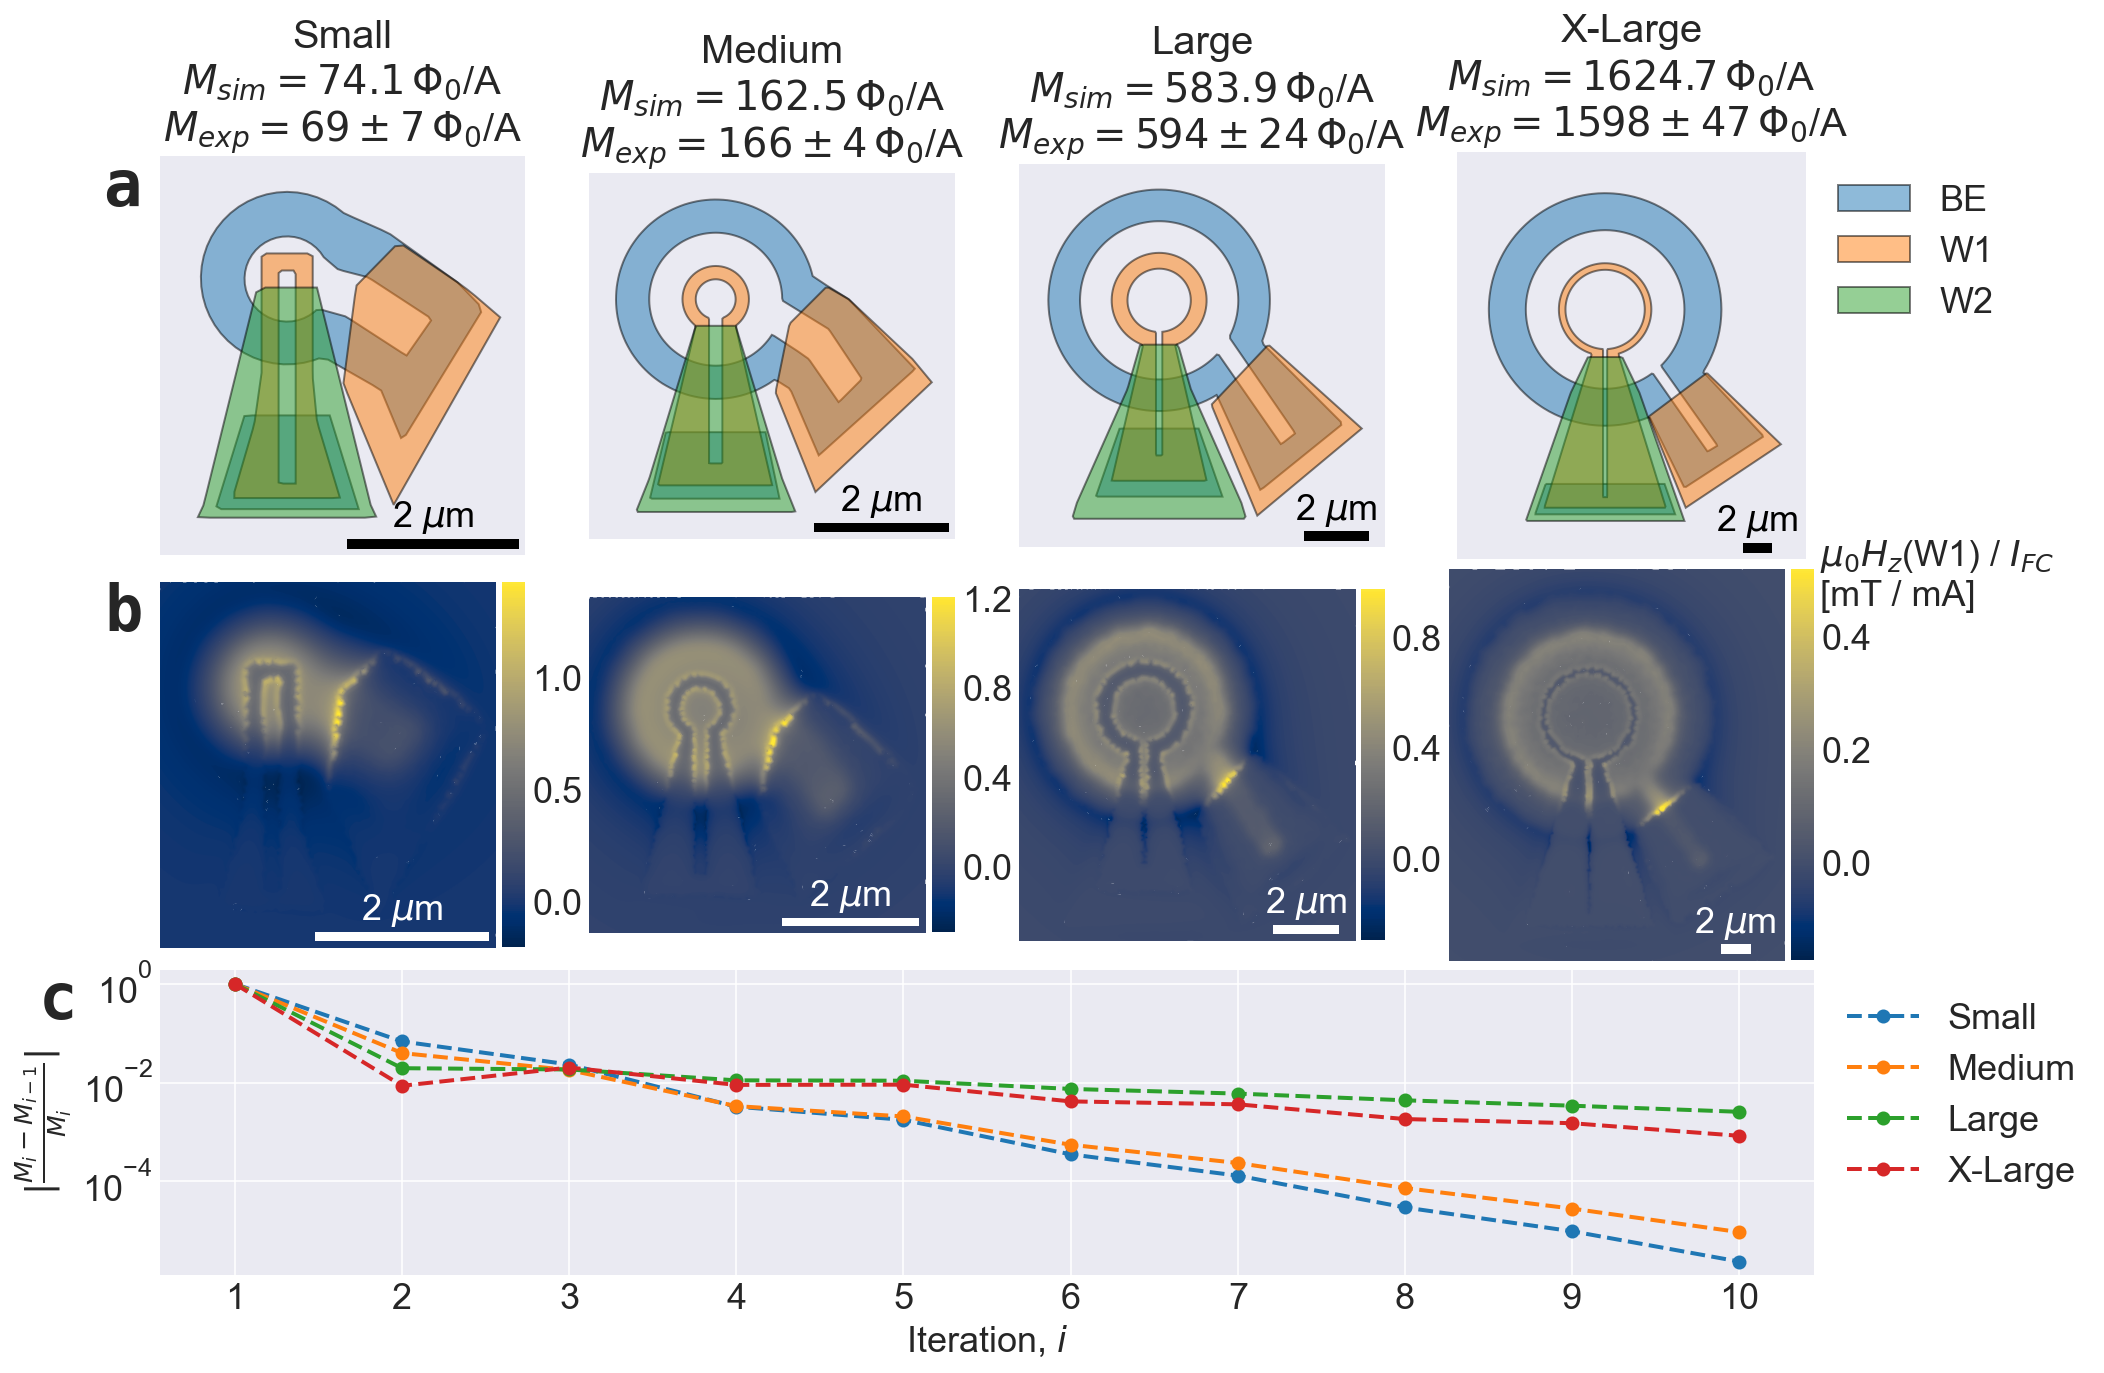

In [19]:
# See Table 1 (second to last column) of https://arxiv.org/pdf/1605.09483.pdf
exp_mutuals = [(69, 7), (166, 4), (594, 24), (1598, 47), (1000, 50)]

fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(3, len(squid_funcs), height_ratios=[1, 1, 0.75])

scale = 2
scalebar_kwargs = dict(
    size=scale,
    loc="lower right",
    label=f"{scale} {um}",
    frameon=False,
    label_top=True,
    pad=0.1,
    fontproperties=fm.FontProperties(size=18),
)
rows = []
axes = []

row = [fig.add_subplot(gs[0, i]) for i, _ in enumerate(squid_funcs)]
rows.append(row)
axes.extend(row)

for ax, (name, make_squid), (nom, err) in zip(row, squid_funcs.items(), exp_mutuals):
    squid = make_squid()
    squid.draw(ax=ax, exclude=exclude, layer_order="decreasing", alpha=0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ymin, ymax = ax.get_ylim()
    scalebar = AnchoredSizeBar(
        transform=ax.transData,
        size_vertical=(ymax - ymin) / 50,
        color="k",
        **scalebar_kwargs
    )
    ax.add_artist(scalebar)
    mutuals = all_mutuals[name]
    title = name + (
        f"\n$M_{{sim}} = {{{mutuals[-1]:.1f}}}\\,\\Phi_0$/A"
        f"\n$M_{{exp}} = {{{nom:.0f}}}\\pm{{{err:.0f}}}\\,\\Phi_0$/A"
    )
    title_split = title.split("\n")
    title = "\n".join(title_split[:1] + title_split[-2:])
    ax.set_title(title, fontsize=20)
    
handles = ax.artists[::2]
labels = ["BE", "W1", "W2"]
ax.legend(handles, labels, bbox_to_anchor=(1, 1), loc="upper left", fontsize=18)

row = [fig.add_subplot(gs[1, i]) for i, _ in enumerate(squid_funcs)]
rows.append(row)
axes.extend(row)

for ax, (name, solutions) in zip(row, all_solutions.items()):
    device = solutions[-1].device
    points = device.points
    triangles = device.triangles
    hz = solutions[-1].field_at_position(points, zs=device.layers["W1"].z0).to("mT")
    hz = (hz / I_fc).to("mT / mA").magnitude
    vmin, vmax = sc.visualization.auto_range_iqr(hz, 0.01)
    levels = np.linspace(vmin, vmax, 201)
    ax.set_aspect("equal")
    im = ax.tricontourf(points[:, 0], points[:, 1], triangles, hz, cmap="cividis", levels=levels)
    for pc in im.collections:
        pc.set_edgecolor("face")
    cax = make_axes_locatable(ax).append_axes("right", size="7%", pad="2%")
    cbar = fig.colorbar(im, cax=cax)
    tick_locator = ticker.MaxNLocator(nbins=4)
    cbar.locator = tick_locator
    cbar.update_ticks()
    ax.axis("off")
    ymin, ymax = ax.get_ylim()
    scalebar = AnchoredSizeBar(
        transform=ax.transData,
        size_vertical=(ymax - ymin) / 50,
        color="w",
        **scalebar_kwargs
    )
    ax.add_artist(scalebar)
    
cbar.ax.set_title(
    "$\\mu_0H_z$(W1) / $I_{FC}$\n[mT / mA]",
    fontsize=18, loc="right", y=0.875, x=1.25, ha="left",
)

ax = fig.add_subplot(gs[2, :])
rows.append([ax])
axes.append(ax)

for (name, mutuals) in all_mutuals.items():
    iterations = np.arange(len(solutions))
    delta_M = np.abs(np.diff(mutuals))
    delta_M = delta_M / np.abs(mutuals[1:])
    ax.plot(iterations[1:], delta_M, "o--", lw=2, label=name.split("\n")[0])
    ax.set_yscale("log")
    ax.set_xticks(iterations[1:])
    label = "$\\left\\|\\frac{M_{i} - M_{i-1}}{M_{i}}\\right\\|$"
ax.set_ylabel(label, fontsize=18)
ax.set_xlabel("Iteration, $i$")

ax.legend(bbox_to_anchor=(1, 1), fontsize=18)

for row, label in zip(rows, string.ascii_lowercase):
    ax = row[0]
    ax.text(
        -0.05, 1, label,
        family="monospace", weight="bold", size=32,
        transform=ax.transAxes, ha="right", va="top",
    )
    
fig.tight_layout()
fig.subplots_adjust(hspace=0.005, wspace=0.175)
    
if SAVE_FIGURES:
    fig.savefig("../images/squid-mutuals.pdf", bbox_inches="tight")